In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import errors as err
import cluster_tools as ct
import sklearn.cluster as cluster
from sklearn.metrics import silhouette_score
pd.options.mode.chained_assignment = None

In [2]:
def read_file(fn):
    """
    Reads a CSV file and returns a pandas DataFrame.

    Parameters:
    ------------    
    fn (str): The filename of the CSV file to be read.

    Returns:
    ---------    
    df (pandas.DatFrame): The DataFrame containing the data 
    read from the CSV file.
    """
    address = fn
    print(address)
    df = pd.read_csv(address, skiprows=4)
    df=df.drop(columns=['Country Code','Indicator Name','Indicator Code','Unnamed: 67'])
    return df

In [3]:
def fit_exponential_and_predict(df,Country_name,Ind,tit,tit_fore):
    # fit exponential growth
    popt, pcorr = opt.curve_fit(exp_growth, df.index, df[Country_name],
    p0=[4e3, 0.001])
    # much better
    print("Fit parameter", popt)
    df["pop_exp"] = exp_growth(df.index, *popt)
    plt.figure()
    plt.plot(df.index, df[Country_name], label="data")
    plt.plot(df.index, df["pop_exp"], label="fit")
    plt.legend()
    plt.xlabel('Years')
    plt.ylabel(Ind)
    plt.title(tit)
    plt.savefig(Country_name+'.png', dpi=300)
    years = np.linspace(1995, 2030)
    print(*popt)
    pop_exp = exp_growth(years, *popt)
    sigma = err.error_prop(years, exp_growth, popt, pcorr)
    low = pop_exp - sigma
    up = pop_exp + sigma
    plt.figure()
    plt.title(tit_fore)
    plt.plot(df.index, df[Country_name], label="data")
    plt.plot(years, pop_exp, label="Forecast")
    # plot error ranges with transparency
    plt.fill_between(years, low, up, alpha=0.5, color="y")
    plt.legend(loc="upper left")
    plt.xlabel('Years')
    plt.ylabel(Ind)
    plt.savefig(Country_name+'_forecast.png', dpi=300)
    plt.show()
    


In [4]:
def get_for_inds(first_ind_name,Second_ind_name,df1,df2,Year):
    df1 = df1[['Country Name', Year]]
    df2 = df2[['Country Name',Year]]
    df = pd.merge(df1, df2,
                   on="Country Name", how="outer")
    df = df.dropna()
    df = df.rename(columns={Year+"_x": first_ind_name, Year+"_y": Second_ind_name})
    df_cluster = df[[first_ind_name, Second_ind_name]].copy()
    return df_cluster

In [5]:
def exp_growth(t, scale, growth):
    """ Computes exponential function with scale and growth as free parameters
    """
    f = scale * np.exp(growth * (t-1990))
    return f


In [6]:
def get_data_for_country(df, country_name, start_year, end_year):
    df = df.T
    df.columns = df.iloc[0]
    df = df.drop(['Country Name'])
    df = df[[country_name]]
    df.index = df.index.astype(int)
    df = df[(df.index >start_year) & (df.index <= end_year)]
    df[country_name] = df[country_name].astype(float)
    return df

In [13]:
def make_clusters(df,ind1,ind2,xlabel,ylabel,tit,n_clu_cen,df_fit,df_min,df_max):
    nc = n_clu_cen # number of cluster centres
    kmeans = cluster.KMeans(n_clusters=nc ,n_init=10, random_state=0)
    kmeans.fit(df_fit)
    # extract labels and cluster centres
    labels = kmeans.labels_
    cen = kmeans.cluster_centers_
    plt.figure()
    # scatter plot with colours selected using the cluster numbers
    # now using the original dataframe
    scatter = plt.scatter(df[ind1], df[ind2], c=labels, cmap="tab10")
    # colour map Accent selected to increase contrast between colours
    # rescale and show cluster centres
    scen = ct.backscale(cen, df_min, df_max)
    xc = scen[:,0]
    yc = scen[:,1]
    plt.scatter(xc, yc, c="k", marker="d", s=80)
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(tit)
    plt.savefig('Clustering_plot.png', dpi=300)
    plt.show()

In [8]:
def plot_silhouette_score(data, max_clusters=10):
    """
    Evaluate and plot silhouette scores for different numbers of clusters.

    Parameters:
    - data: The input data for clustering.
    - max_clusters: The maximum number of clusters to evaluate.

    Returns: 
    """

    silhouette_scores = []

    for n_clusters in range(2, max_clusters + 1):
        # Perform clustering using KMeans
        kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(data)

        # Calculate silhouette score
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    # Plot the silhouette scores
    plt.figure(figsize=(8, 6))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.title('Silhouette Score for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

CO2_emissions_metric_tons_per_capita.csv
Renewable_energy_consumption_percentage.csv


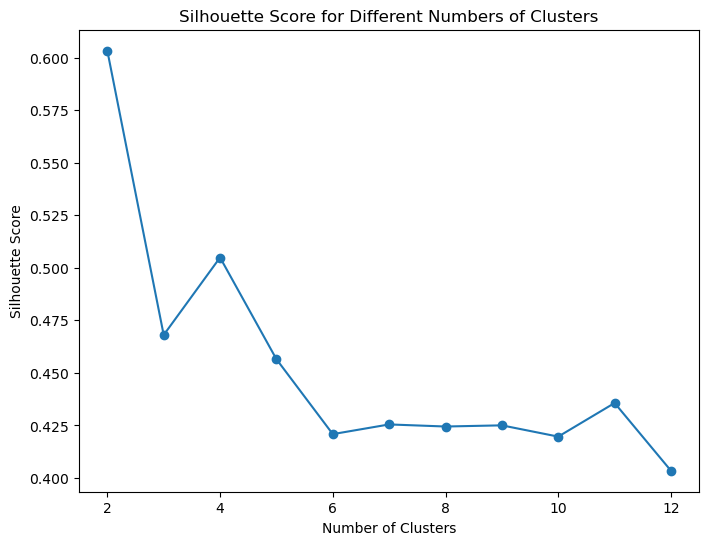

In [10]:
CO2_emissions_metric_tons_per_capita = read_file('CO2_emissions_metric_tons_per_capita.csv')
Renewable_energy_consumption_percentage = read_file('Renewable_energy_consumption_percentage.csv')
df_cluster = get_for_inds('Renewable_energy_consumption_percentage','CO2_emissions_metric_tons_per_capita',Renewable_energy_consumption_percentage,CO2_emissions_metric_tons_per_capita,'2020')

df_fit, df_min, df_max = ct.scaler(df_cluster)
plot_silhouette_score(df_fit,12)

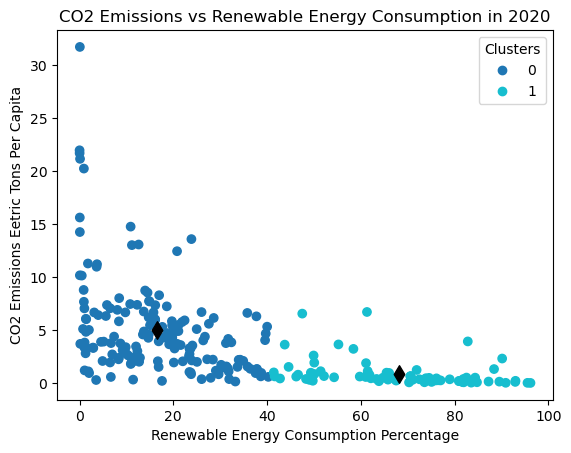

In [21]:
make_clusters(df_cluster,'Renewable_energy_consumption_percentage','CO2_emissions_metric_tons_per_capita','Renewable Energy Consumption Percentage','CO2 Emissions Eetric Tons Per Capita','CO2 Emissions vs Renewable Energy Consumption in 2020',2,df_fit,df_min,df_max)

Fit parameter [2.0689349  0.04839443]
2.068934897580442 0.048394434015455644


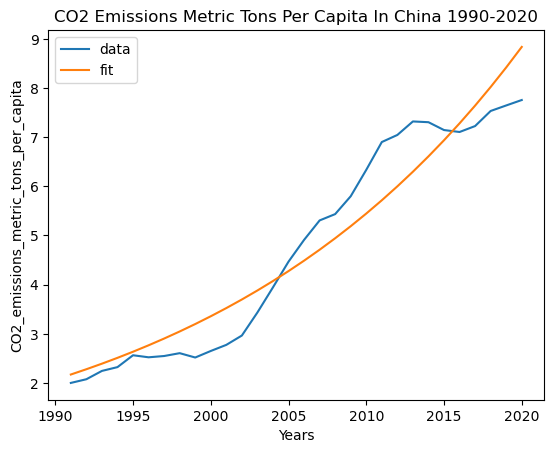

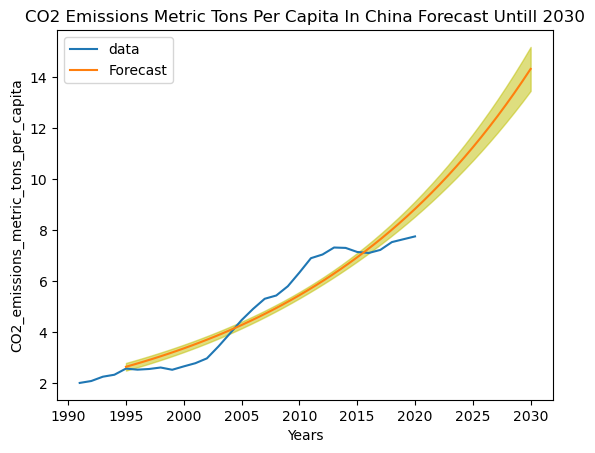

Fit parameter [ 1.14634644e+01 -1.04946761e-02]
11.463464358432038 -0.0104946761320253


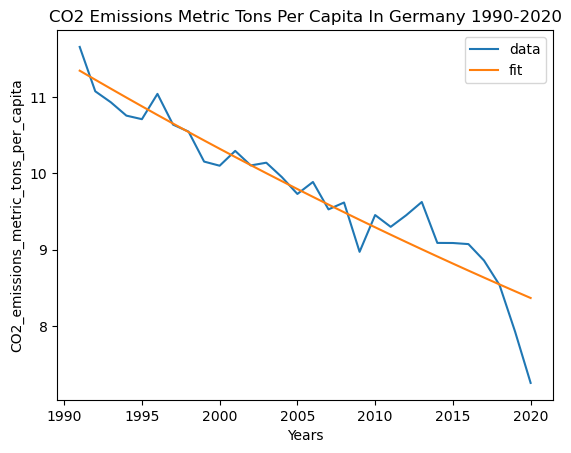

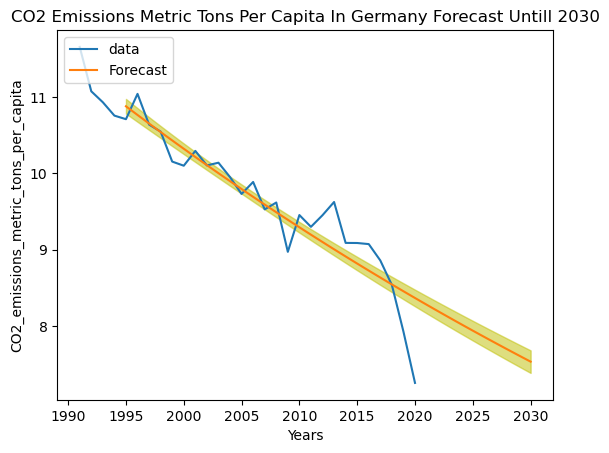

In [19]:
df = get_data_for_country(CO2_emissions_metric_tons_per_capita,'China', 1990, 2020)
df = df.fillna(0)
fit_exponential_and_predict(df,'China','CO2_emissions_metric_tons_per_capita',"CO2 Emissions Metric Tons Per Capita In China 1990-2020","CO2 Emissions Metric Tons Per Capita In China Forecast Untill 2030")
df = get_data_for_country(CO2_emissions_metric_tons_per_capita,'Germany', 1990, 2020)
df = df.fillna(0)
fit_exponential_and_predict(df,'Germany','CO2_emissions_metric_tons_per_capita',"CO2 Emissions Metric Tons Per Capita In Germany 1990-2020","CO2 Emissions Metric Tons Per Capita In Germany Forecast Untill 2030")

Fit parameter [37.84441787 -0.04318649]
37.84441786541816 -0.0431864913560302


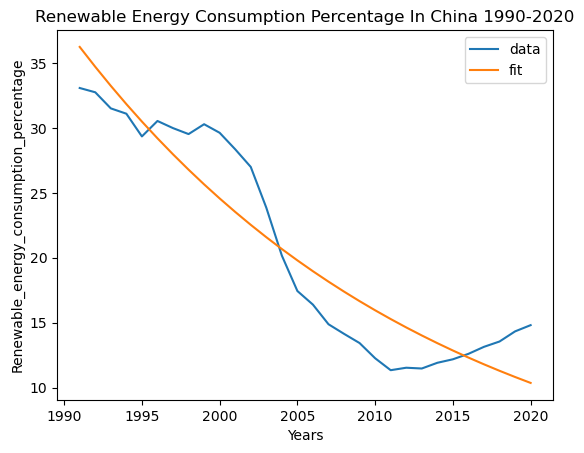

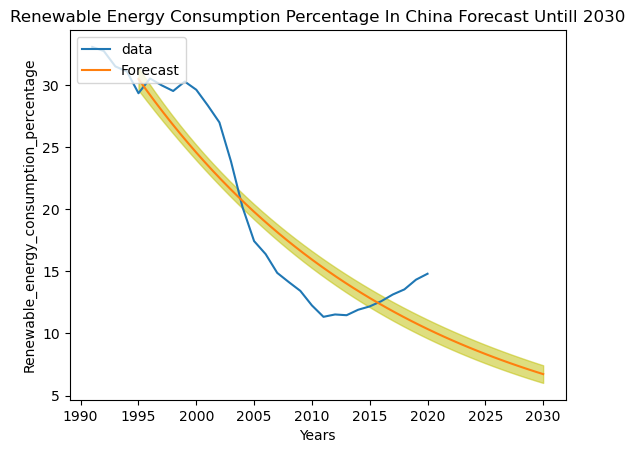

Fit parameter [2.47426322 0.06932935]
2.474263215055922 0.06932935447858536


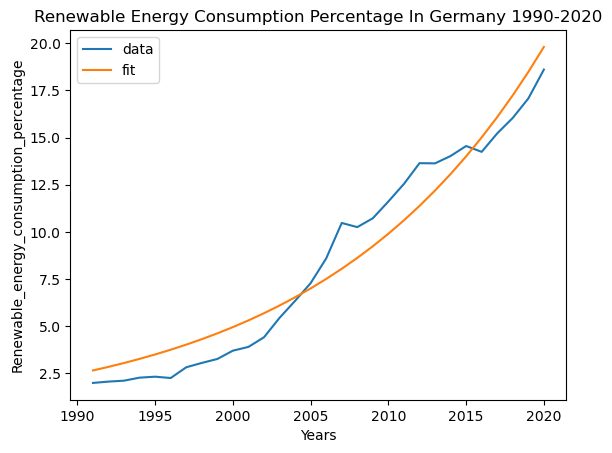

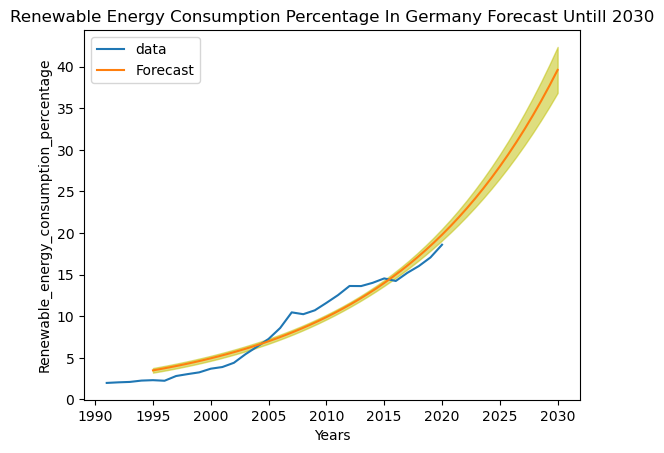

In [20]:
df = get_data_for_country(Renewable_energy_consumption_percentage,'China', 1990, 2020)
df = df.fillna(0)
fit_exponential_and_predict(df,'China','Renewable_energy_consumption_percentage',"Renewable Energy Consumption Percentage In China 1990-2020","Renewable Energy Consumption Percentage In China Forecast Untill 2030")
df = get_data_for_country(Renewable_energy_consumption_percentage,'Germany', 1990, 2020)
df = df.fillna(0)
fit_exponential_and_predict(df,'Germany','Renewable_energy_consumption_percentage',"Renewable Energy Consumption Percentage In Germany 1990-2020","Renewable Energy Consumption Percentage In Germany Forecast Untill 2030")